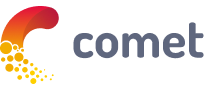

Data science and machine learning teams use [Comet](https://www.comet.com/signup?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)'s ML platform to track, compare, explain, and optimize their models across the complete ML lifecycle – from managing experiments to monitoring models in production.

Comet improves productivity, reproducibility, and collaboration, regardless of the tools used for training and deploying models, whether they are managed, open-source, or in-house. The platform can be used on the cloud, virtual private cloud (VPC), or on-premises.

- 💽 [Manage and version your training data](https://www.comet.com/site/products/artifacts-dataset-management?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

- 📈 [Track and compare training runs](https://www.comet.com/site/products/ml-experiment-tracking/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

- 📒 [Create a Model Registry](https://www.comet.com/site/products/machine-learning-model-versioning/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

- 🔎 [Monitor your Models in Production](https://www.comet.com/site/products/model-production-monitoring/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet) 

All in one place!

The best part? [It's 100% free to get started!](https://www.comet.com/signup?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

---

To find out more about Comet, visit our Documentation Page

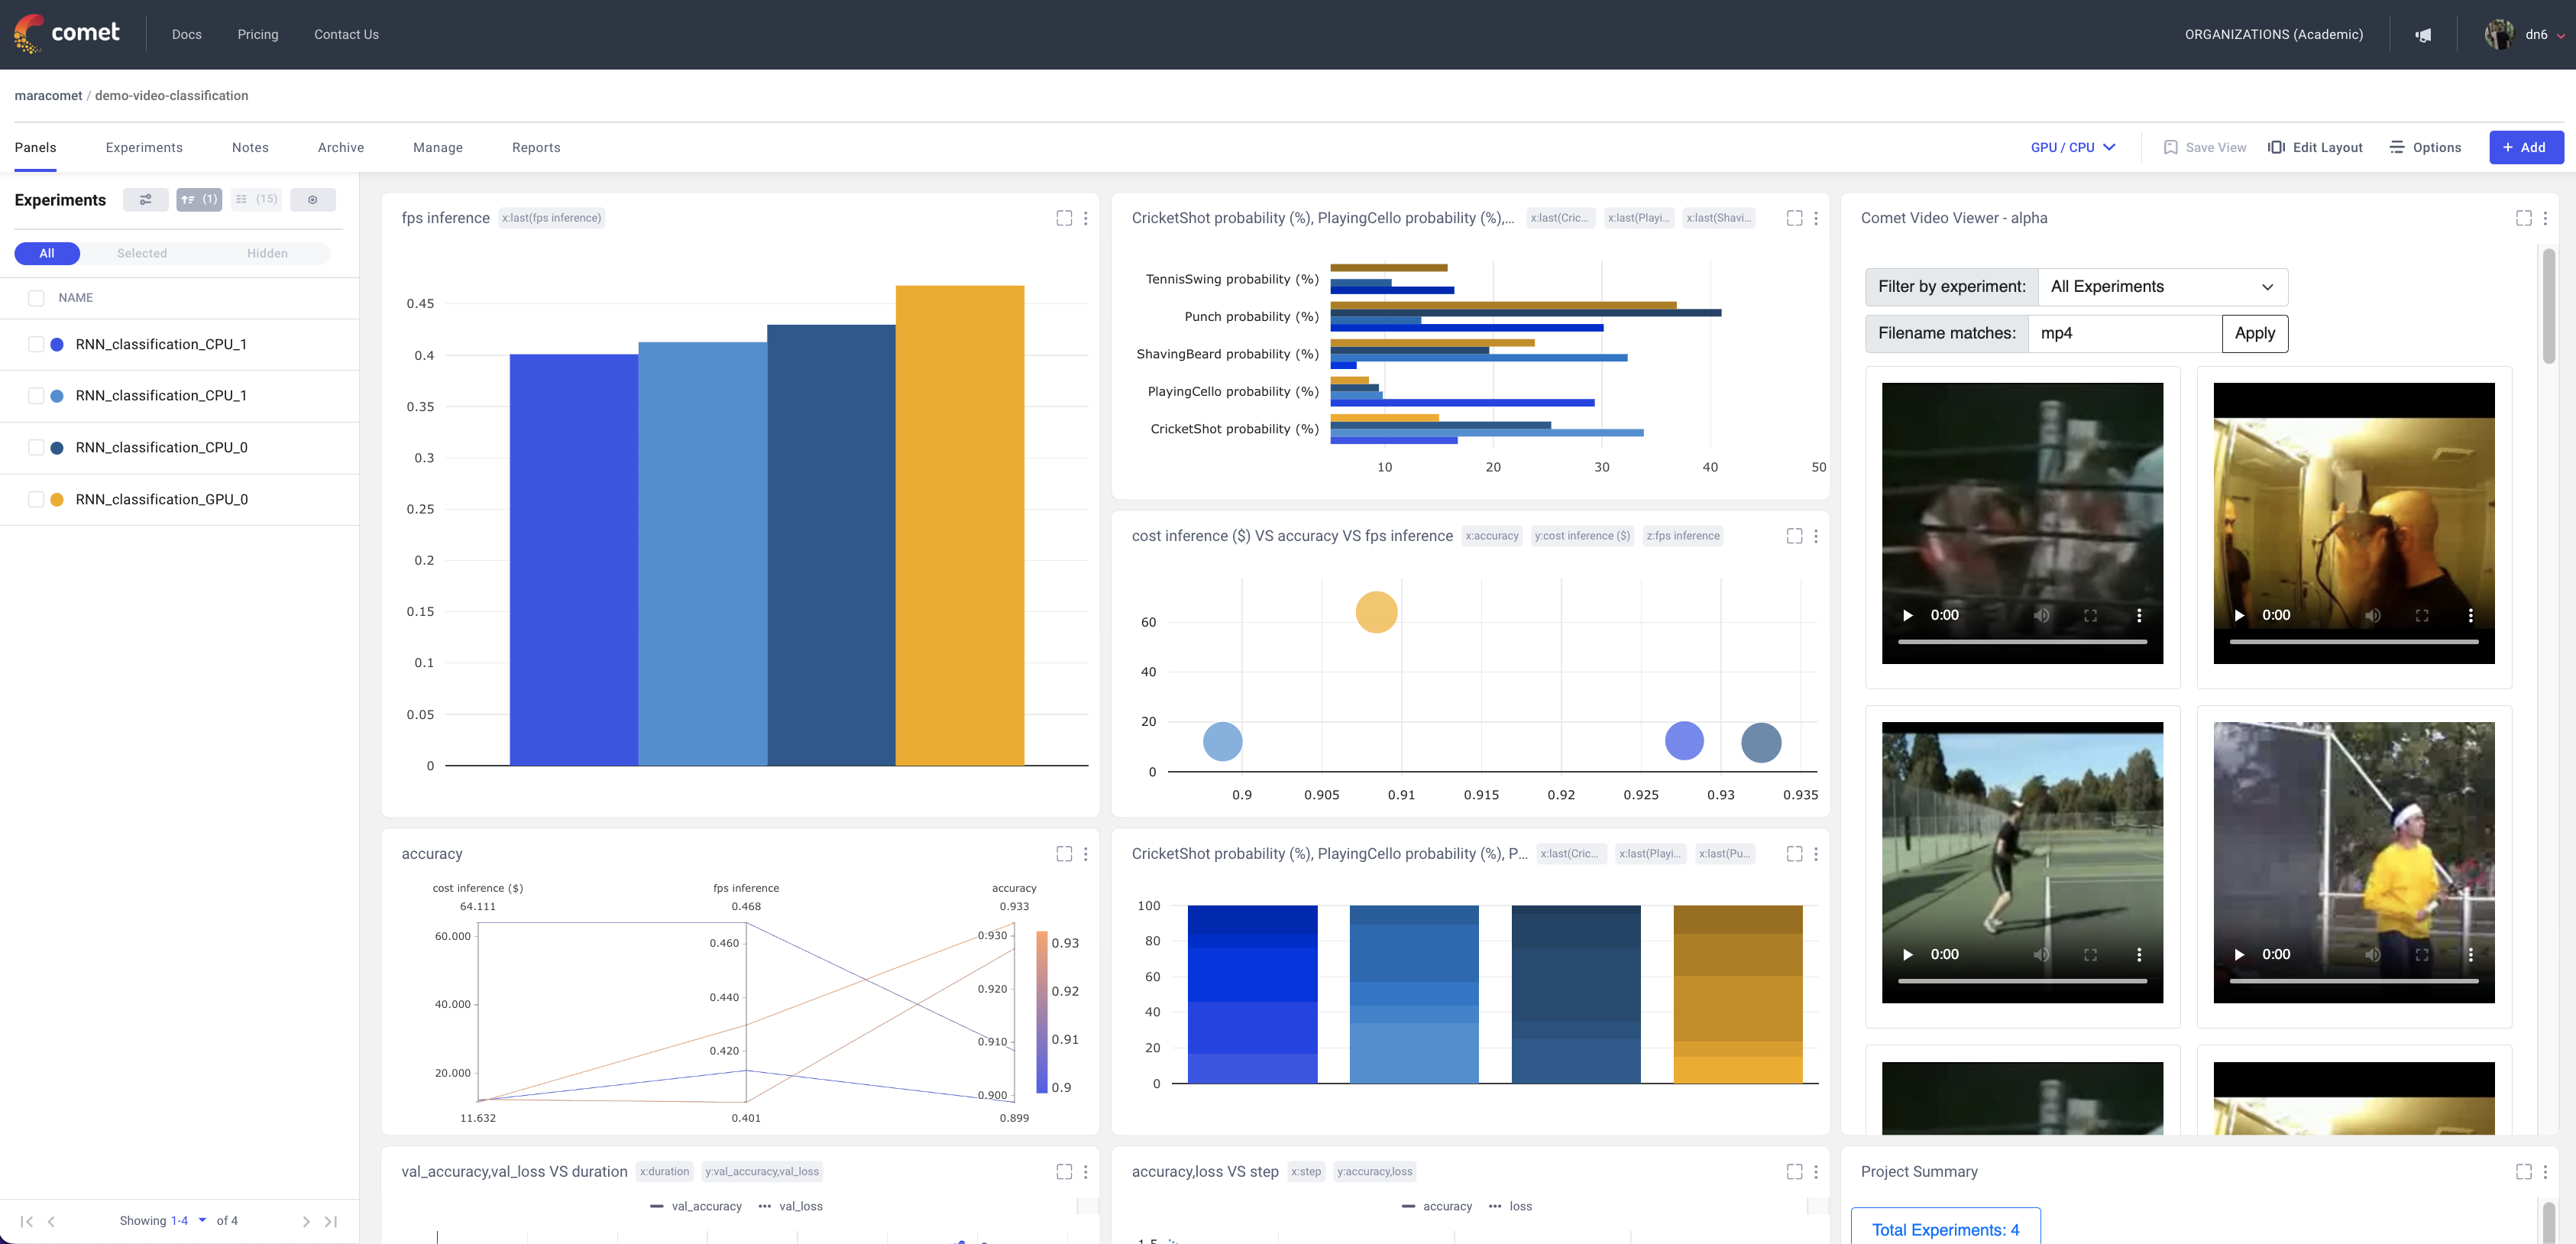

In this guide we will cover some of the basic features for logging data to Comet. 

For a preview of what's possible with Comet, head over to one of our example projects on [Video Classification](If you'd like to take a look at a full project, click the link below:

[Comet Video Classification](https://www.comet.com/maracomet/demo-video-classification/view/5jQkOgv2xebriYq8gdieVtMFy/panels?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)



# 🔧 Install Comet

In [ ]:
%pip install -U comet_ml "numpy<2.0.0"

# 💥 Initialize Comet and grab your Credentials

In [ ]:
import comet_ml

comet_ml.init(project_name="comet-example-intro-to-comet")

# 🚀 Let's start logging Experiments! 

## Basics of Logging with Comet

Interested in running a full model training example? Skip to the [Training Models with Comet](#scrollTo=Kqpnx4Y-P97u) section

### Creating an Experiment

A Comet Experiment is a unit of measurable research that defines a single run with some data/parameters/code/metrics.

In [ ]:
experiment = comet_ml.Experiment()

Comet supports logging metrics, parameters, source code, system information, models and media. You name it, we can log it!

In the sections below, we will walkthrough the basic methods for logging data to Comet. In addition to these methods, Comet also supports auto-logging data based on the framework you are using. This means that once you have created the Experiment object in your code, you can run it as is, and Comet will take care of the logging for you! 

If Auto-Logging isn't enough, Comet is infinitely customizable to your specific needs! 

[Learn more about Auto-Logging](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/experiment-overview/#automatic-logging?medium=referral&source=comet_notebook&term=introduction_to_comet)

### Logging Metrics

In [ ]:
metrics = {"accuracy": 0.65, "loss": 0.01}
experiment.log_metrics(metrics)

### Logging Metrics Over Time

In [ ]:
for step, value in enumerate(range(0, 100)):
    metrics = {"train/accuracy": value / 10, "validation/accuracy": value / 20}
    experiment.log_metrics(metrics, step=step)

### Logging Parameters

In [ ]:
parameters = {"batch_size": 32, "num_samples": 10000}
experiment.log_parameters(parameters)

### End the Experiment

Once you are finished with your run, end the Experiment to stop logging to Comet. Experiments also automatically end when your script finishes. 

In [ ]:
experiment.end()

## Training Models with Comet

### Pytorch

Don't want to wait? Check out a completed run using [Comet with Pytorch](https://www.comet.com/examples/comet-example-pytorch-mnist/cc4a4f7636af485aaeaac2de8f462c0d?experiment-tab=chart&showOutliers=true&smoothing=0&transformY=smoothing&xAxis=wall?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

In [ ]:
%pip install -U torch torchvision tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from comet_ml.integration.pytorch import log_model
from tqdm import tqdm

# Create an Experiment
experiment = comet_ml.Experiment()

hyper_params = {"batch_size": 100, "num_epochs": 2, "learning_rate": 0.01}
experiment.log_parameters(hyper_params)
experiment.add_tags(["intro-pytorch"])

# MNIST Dataset
dataset = datasets.MNIST(
    root="./data/", train=True, transform=transforms.ToTensor(), download=True
)

# Data Loader (Input Pipeline)
dataloader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=hyper_params["batch_size"], shuffle=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, optimizer, criterion, dataloader, epoch, experiment):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (images, labels) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        pred = outputs.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability

        loss.backward()
        optimizer.step()

        # Compute train accuracy
        batch_correct = pred.eq(labels.view_as(pred)).sum().item()
        batch_total = labels.size(0)

        total_loss += loss.item()
        correct += batch_correct

        # Log batch_accuracy to Comet; step is each batch
        experiment.log_metric("batch_accuracy", batch_correct / batch_total)

    total_loss /= len(dataloader.dataset)
    correct /= len(dataloader.dataset)

    experiment.log_metrics({"accuracy": correct, "loss": total_loss}, epoch=epoch)


model = Net().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params["learning_rate"])

# Train the Model
with experiment.train():
    print("Running Model Training")
    for epoch in range(hyper_params["num_epochs"]):
        train(model, optimizer, criterion, dataloader, epoch, experiment)

log_model(experiment, model, "mnist-classifier")
experiment.end()

### Hugging Face

Don't want to wait? Check out a completed run using [Comet with Hugging Face Transformers](https://www.comet.com/examples/comet-examples-transformers-trainer/fe01946945a44d7c880139006bb538e8?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

#### Setup

In [ ]:
%pip install -U comet_ml torch datasets "transformers<4.40.0" scikit-learn accelerate

In [ ]:
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased"
SEED = 42

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

raw_datasets = load_dataset("imdb")
train_dataset = raw_datasets["train"].shuffle(seed=SEED).select(range(200))
eval_dataset = raw_datasets["test"].shuffle(seed=SEED).select(range(200))

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, num_labels=2
)


def get_example(index):
    return eval_dataset[index]["text"]


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

#### Run Training

Notice how we do not have to create an Experiment object when using Hugging Face's Transformers. This is because Comet is integrated into the `Trainer` object, which means that if you have Comet installed in your environment, you will automatically be able to log training runs from Transfomers.  

In [ ]:
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

training_args = TrainingArguments(
    seed=SEED,
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=1,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_total_limit=10,
    save_steps=25,
    per_device_train_batch_size=8,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)
trainer.train()

### Keras

Don't want to wait? Check out a completed training run using [Comet with Keras](https://www.comet.com/examples/comet-example-keras-notebook/ef20812c7b1d4876a7cbd5679a12c309?experiment-tab=panels&showOutliers=true&smoothing=0&transformY=smoothing&xAxis=step?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

In [ ]:
%pip install -U tensorflow

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras

experiment = comet_ml.Experiment(
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)
experiment.add_tags(["intro-keras"])

batch_size = 128
num_classes = 10
epochs = 5
num_nodes = 64
optimizer = "adam"
activation = "relu"

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# these will all get logged
params = {
    "batch_size": batch_size,
    "epochs": epochs,
    "layer1_type": "Dense",
    "layer1_num_nodes": num_nodes,
    "layer1_activation": activation,
    "optimizer": optimizer,
}

model = Sequential()
model.add(Dense(num_nodes, activation="relu", input_shape=(784,)))
model.add(Dense(256, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

# print model.summary() to preserve automatically in `Output` tab
print(model.summary())

model.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

# will log metrics with the prefix 'train_'
with experiment.train():
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test),
        callbacks=[
            EarlyStopping(
                monitor="val_loss", min_delta=1e-4, patience=3, verbose=1, mode="auto"
            )
        ],
    )

# will log metrics with the prefix 'test_'
with experiment.test():
    loss, accuracy = model.evaluate(x_test, y_test)
    metrics = {"loss": loss, "accuracy": accuracy}
    experiment.log_metrics(metrics)

experiment.log_dataset_hash(x_train)  # creates and logs a hash of your data
experiment.end()

# Next Steps

In this guide we covered the absolute basics of logging with Comet. 

In addition to metrics and parameters, Comet is capable of logging rich media assets, models, dataframes, and much more. For a full list of logging capabilities visit our [Experiment documentation](https://www.comet.com/docs/v2/api-and-sdk/python-sdk/reference/Experiment/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet) 

Comet also integrates with all your favorite ML frameworks and tools. Head over to our [Integrations Page](https://www.comet.com/docs/v2/integrations/overview/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet) to find out more! 

# Additional Resources

- [Guide on creating customized visualizations using Comet Panels](https://www.comet.com/docs/v2/guides/comet-dashboard/code-panels/about-panels/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

- [Guide on Using Comet's Model Registry](https://www.comet.com/docs/v2/guides/model-management/using-model-registry/?utm_medium=referral&utm_source=comet_notebook&utm_term=introduction_to_comet)

- [Guide on Debugging Models with Comet's Interactive Confusion Matrix](https://colab.research.google.com/github/comet-ml/comet-examples/blob/master/notebooks/Comet-Confusion-Matrix.ipynb)

- [Guide on Managing Datasets with Comet Artifacts](https://colab.research.google.com/github/comet-ml/comet-examples/blob/master/guides/manage_data/Introduction_to_Artifacts.ipynb)

